## Importing libraries

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [229]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", usecols = ["day", "TS_actual", "VS_actual", "PH100", "TI100_PV", "reactor1"])
df.sort_index(inplace=True)
df.head()

,TS_actual,VS_actual,PH100,TI100_PV,reactor1
day,,,,,
0,369.5930,338.3879,8.074410,36.000625,0
1,357.2494,326.3529,8.096889,35.664028,100
2,344.9058,314.3179,7.870299,35.768889,120
3,332.5622,302.2829,7.774347,35.843681,100
4,320.2186,290.2479,7.733986,35.853194,100


## Plotting the different values
This section takes a look at the trend in the biogas values, VS and TS values.

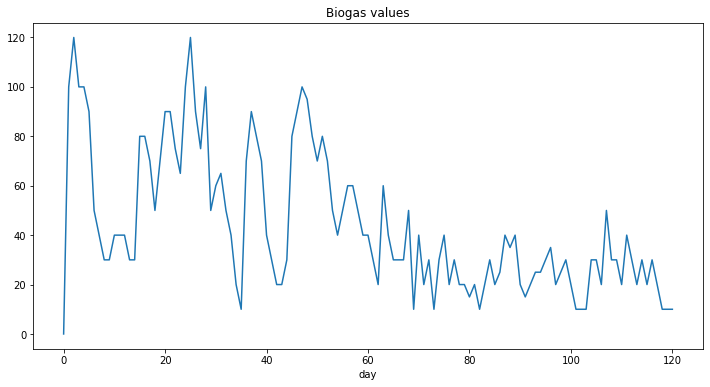

In [230]:
# Biogas values
df["reactor1"].plot(figsize=(12,6), title= "Biogas values")

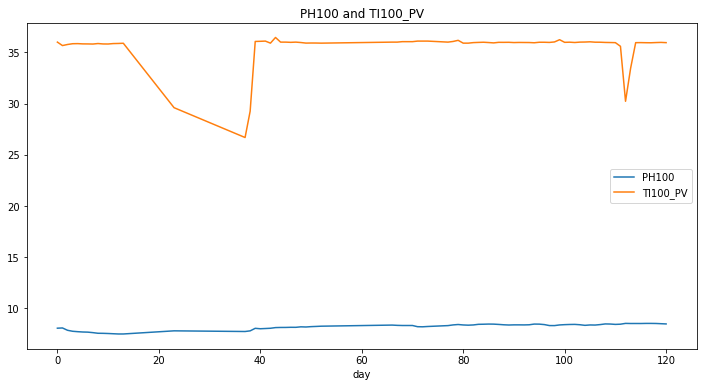

In [231]:
df[["PH100", "TI100_PV"]].plot(figsize=(12,6), legend=True, title = "PH100 and TI100_PV")

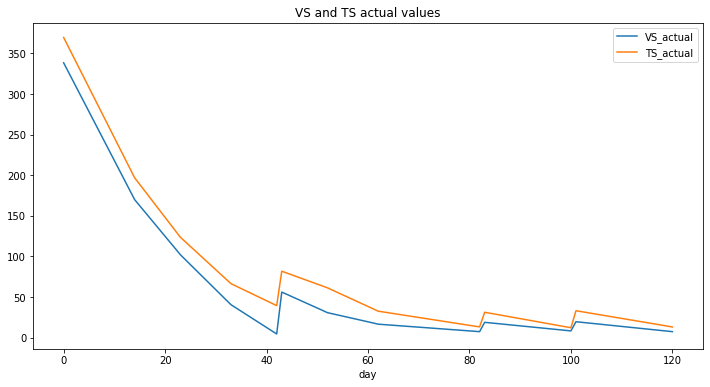

In [232]:
df[["VS_actual", "TS_actual"]].plot(figsize=(12,6), legend=True, title = "VS and TS actual values")

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

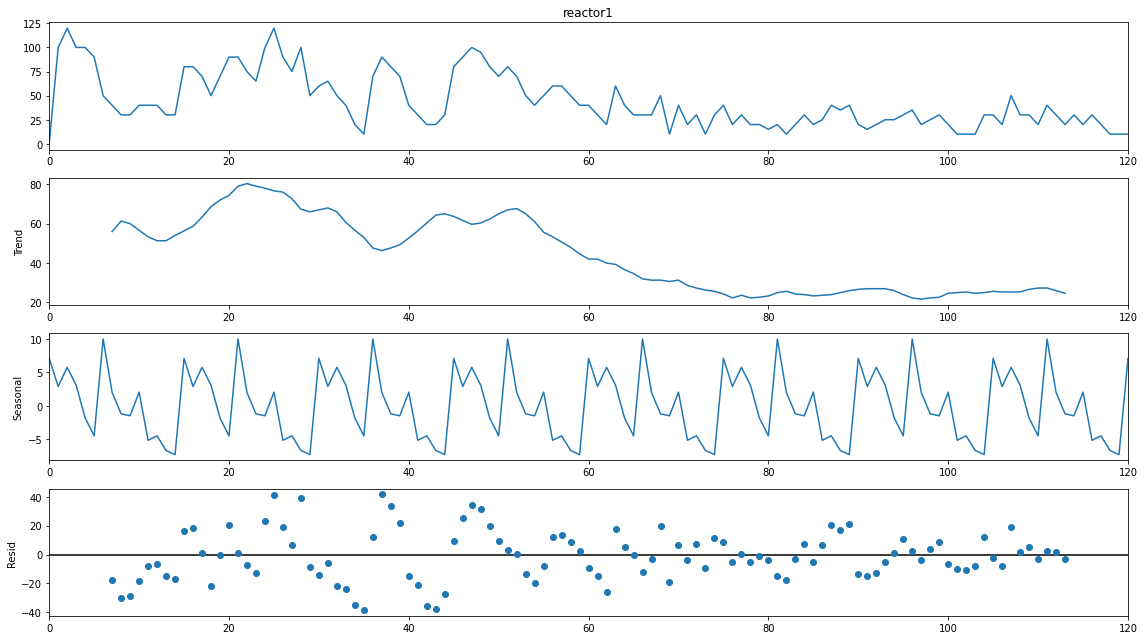

In [233]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x= df['reactor1'],  period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [234]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [235]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), :]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, -1])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 3
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

117

## Splitting into train and test set
This needs to be done sequentially.

In [236]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building LSTM models

## Input shape
LSTMs expect input array to be a 3D array: (batch_size, time_steps, seq_len)
* `batch_size` = Number of inputs in the training data
* `time_steps` = Number of historical datapoints being given
* `seq_len` = Number of features in a single historical datapoint

Example 1: If there are 2500 training sentences, with 50 words in each, with each word being encoded as an integer, then the input shape would be: `(2500, 50, 1)` 

So, for univariate analysis, the input shape will be:  
`(num_training_observations, sequence_size, 1)`

For multivariate analysis, the shape does not need to change.


## a) Single LSTM layer (64 neurons)

In [67]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 262ms/step - loss: 1.2103 - val_loss: 0.7549
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0004 - val_loss: 0.5888
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.8618 - val_loss: 0.4528
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7813 - val_loss: 0.3529
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7376 - val_loss: 0.2832
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7067 - val_loss: 0.2355
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6933 - val_loss: 0.2005
Epoch 8/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6767 - val_loss: 0.1776
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6563 - val_loss: 0.1644
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6334 - val_loss: 0.1572
Epoch 11/100
3/3 [

### Plotting the loss

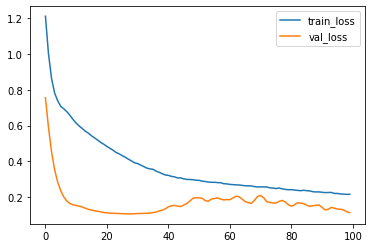

In [69]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 6ms/step


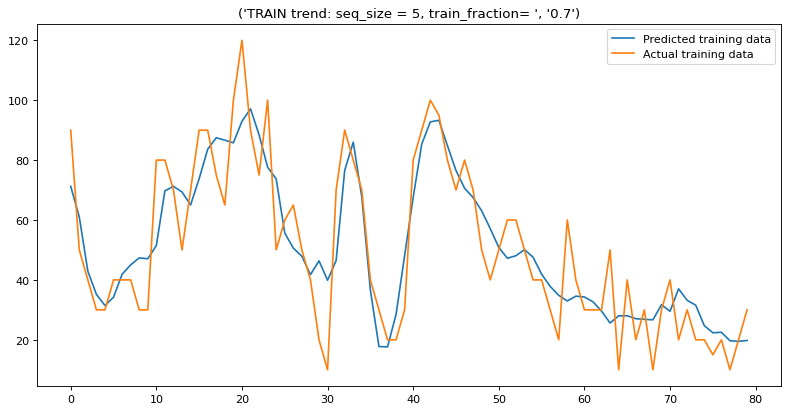

In [70]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 4ms/step


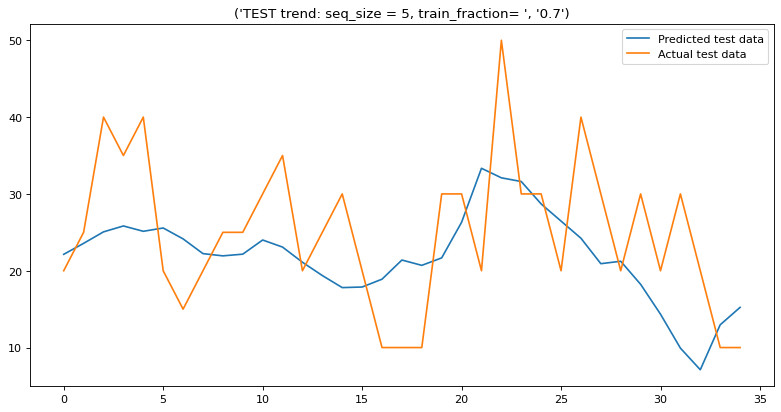

In [71]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

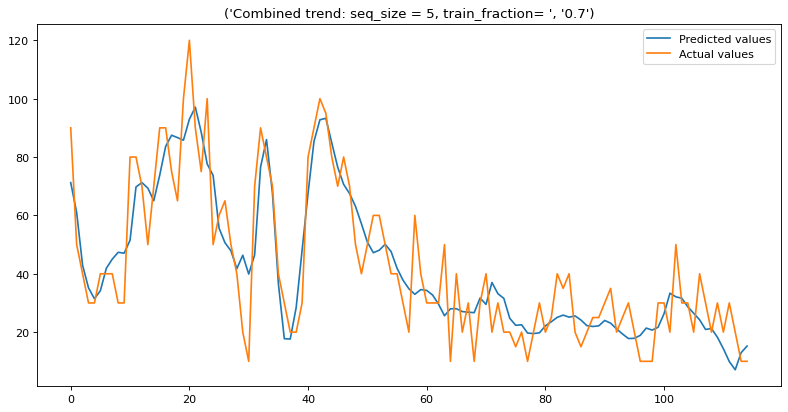

In [72]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [73]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.768 ,  0.033 ,  0.785


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [74]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  12.905 ,  9.404 ,  11.948


### Analysis
**1. Sequence size of 5, train size of 0.7**  
1. Trend is followed on train data with a slight lag initially, and more generalization towards the end.
2. Test data: Highly generalised, smooth curve with values mostly near the mean.
3. r2 score:  0.768 ,  0.033 ,  0.785
4. RMSE:  12.905 ,  9.404 ,  11.948


## b) 1 LSTM + 1 Dense layer

In [135]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 20)                2080      
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [136]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 268ms/step - loss: 1.0270 - val_loss: 0.2841
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9745 - val_loss: 0.2422
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9263 - val_loss: 0.2045
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.8816 - val_loss: 0.1767
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8437 - val_loss: 0.1562
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8045 - val_loss: 0.1416
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.7727 - val_loss: 0.1296
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7430 - val_loss: 0.1216
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.7144 - val_loss: 0.1170
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6935 - val_loss: 0.1148
Epoch 11/100
3/3 [

### Plotting the loss

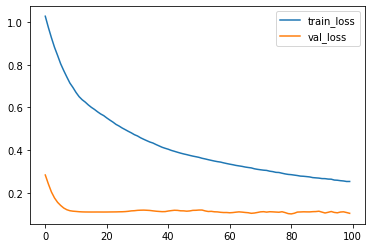

In [137]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 4ms/step


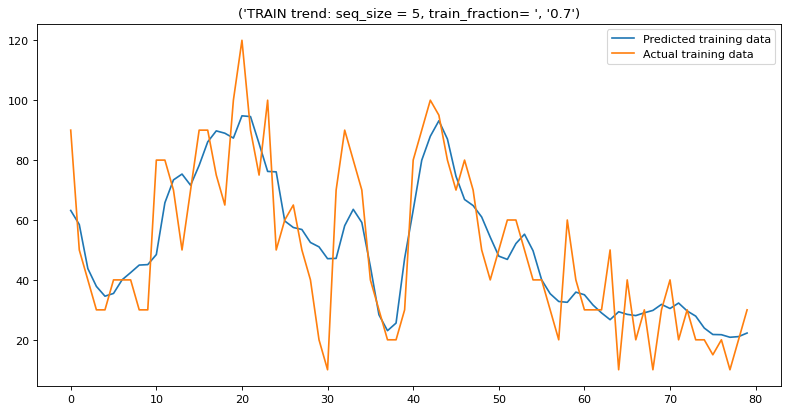

In [138]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 6ms/step


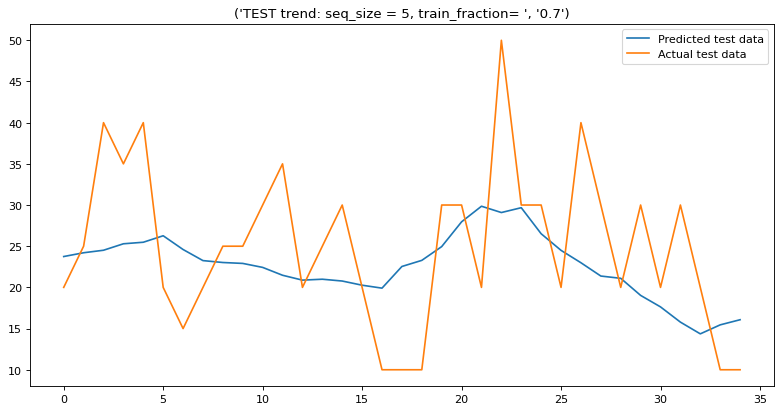

In [139]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

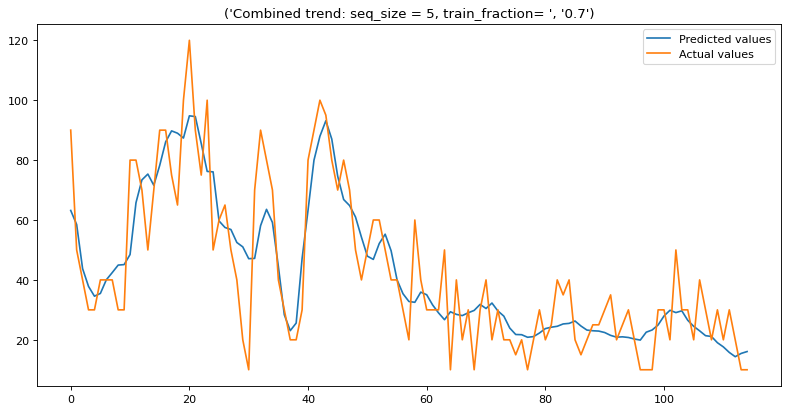

In [140]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [141]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.725 ,  0.102 ,  0.756


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [142]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  14.034 ,  9.059 ,  12.727


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. Highly generalised values. Test data hovers around the mean, with very slight resemblance to the trend.
2. r2 score:  0.725 ,  0.102 ,  0.756
3. RMSE:  14.034 ,  9.059 ,  12.727



## c) 2 LSTM layers 


In [186]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 20)             2080      
                                                                 
 lstm_13 (LSTM)              (None, 20)                3280      
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________


In [187]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 8s 907ms/step - loss: 1.0017 - val_loss: 0.4685
Epoch 2/100
3/3 [==============================] - 0s 77ms/step - loss: 0.9656 - val_loss: 0.4503
Epoch 3/100
3/3 [==============================] - 0s 72ms/step - loss: 0.9335 - val_loss: 0.4283
Epoch 4/100
3/3 [==============================] - 0s 76ms/step - loss: 0.9050 - val_loss: 0.4047
Epoch 5/100
3/3 [==============================] - 0s 67ms/step - loss: 0.8788 - val_loss: 0.3811
Epoch 6/100
3/3 [==============================] - 0s 104ms/step - loss: 0.8522 - val_loss: 0.3577
Epoch 7/100
3/3 [==============================] - 0s 29ms/step - loss: 0.8308 - val_loss: 0.3326
Epoch 8/100
3/3 [==============================] - 0s 31ms/step - loss: 0.8058 - val_loss: 0.3070
Epoch 9/100
3/3 [==============================] - 0s 35ms/step - loss: 0.7783 - val_loss: 0.2828
Epoch 10/100
3/3 [==============================] - 0s 36ms/step - loss: 0.7574 - val_loss: 0.2621
Epoch 11/100
3/3 

### Plotting the loss

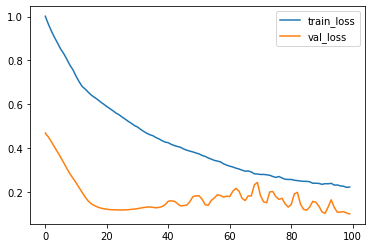

In [188]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


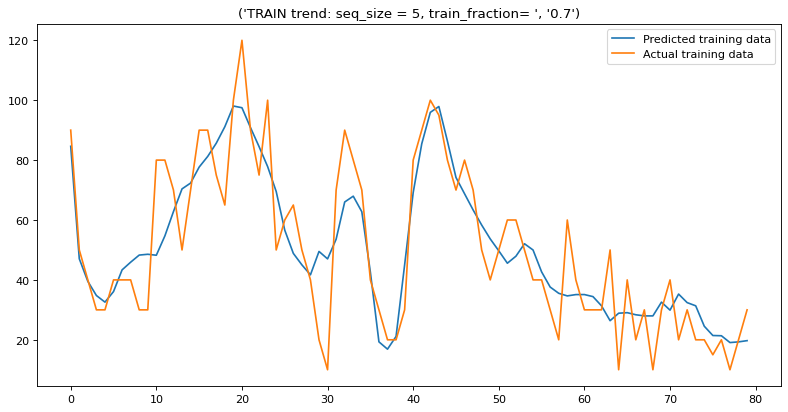

In [189]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 5ms/step


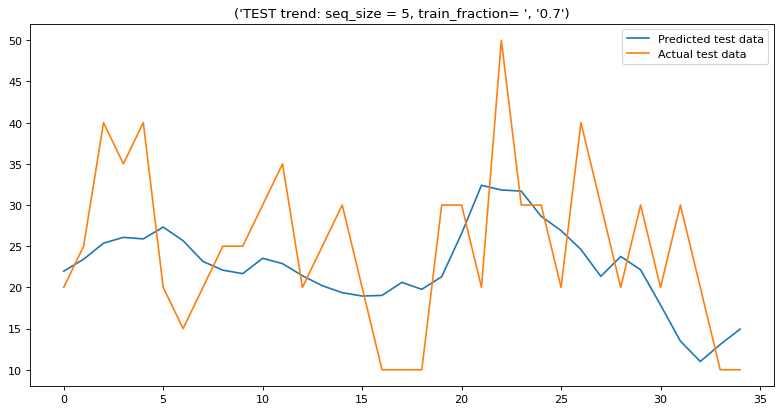

In [190]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

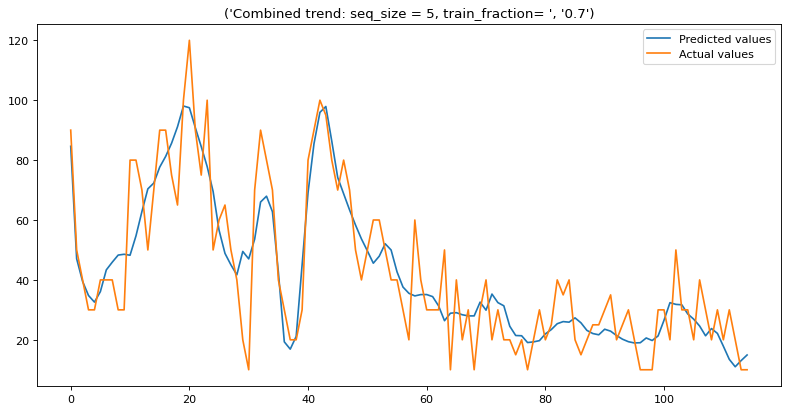

In [191]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [192]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.762 ,  0.151 ,  0.785


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [193]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  13.065 ,  8.812 ,  11.932


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. Sort of like an envelope for the entire series, smooth curve.
2. Test data: Near the mean, follows the trend to some extent in a smooth manner.
3. r2 score:  0.762 ,  0.151 ,  0.785
4. RMSE:  13.065 ,  8.812 ,  11.932





## d) 2 LSTM layers + 1 Dense layer


In [237]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 3, 20)             2080      
                                                                 
 lstm_19 (LSTM)              (None, 20)                3280      
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,801
Trainable params: 5,801
Non-trainable params: 0
_________________________________________________________________


In [238]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 5s 342ms/step - loss: 1.0462 - val_loss: 0.5779
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0289 - val_loss: 0.5708
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0118 - val_loss: 0.5648
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 0.9944 - val_loss: 0.5584
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9773 - val_loss: 0.5529
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.9612 - val_loss: 0.5457
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9444 - val_loss: 0.5393
Epoch 8/100
3/3 [==============================] - 0s 19ms/step - loss: 0.9251 - val_loss: 0.5299
Epoch 9/100
3/3 [==============================] - 0s 20ms/step - loss: 0.9042 - val_loss: 0.5182
Epoch 10/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8808 - val_loss: 0.5043
Epoch 11/100
3/3 [

### Plotting the loss

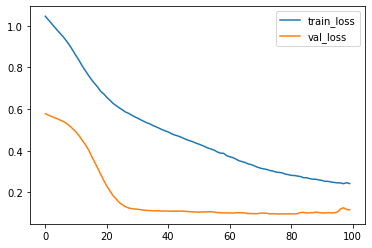

In [239]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


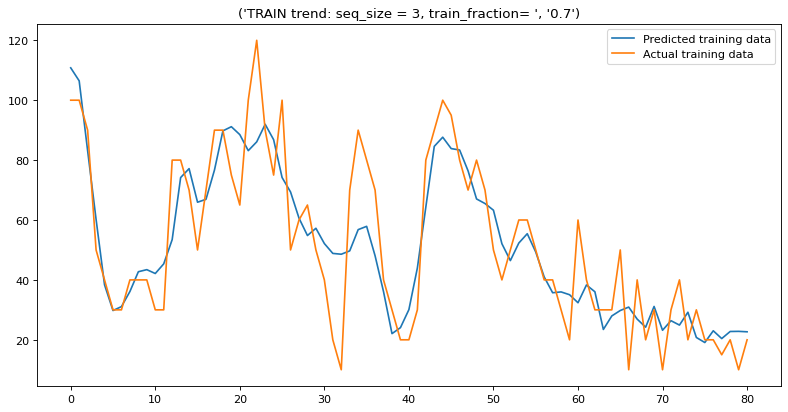

In [240]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 6ms/step


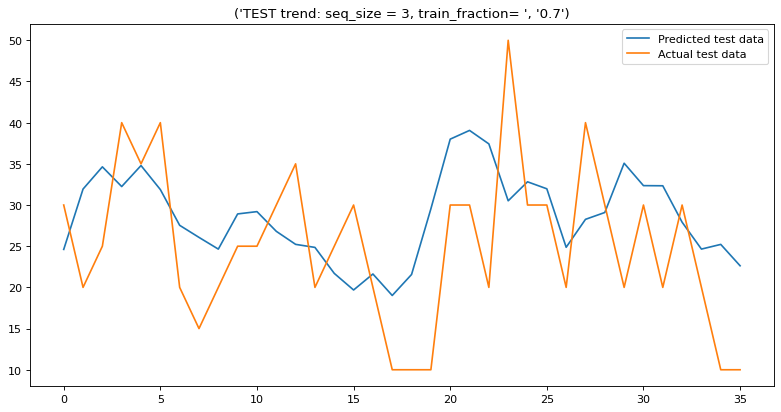

In [241]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

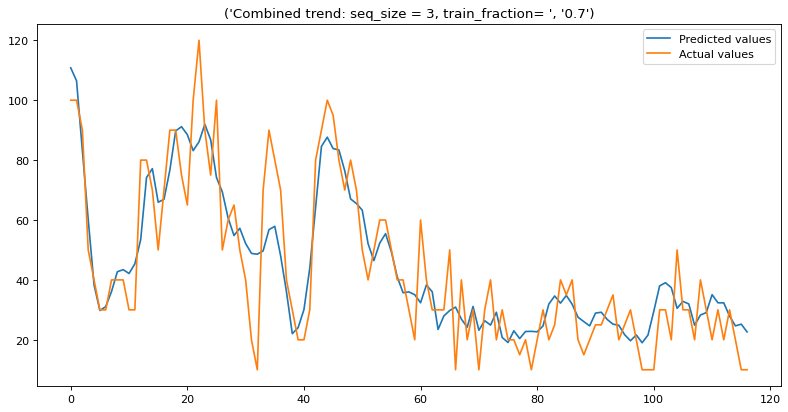

In [242]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [243]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.756 ,  -0.016 ,  0.778


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [244]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  13.643 ,  9.54 ,  12.525


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Slight lag on train data in the beginning.
2. Slight lead on the test data.
3. Curve is not smooth, but captures the overall trend nicely.
4. r2 score:  0.756 ,  -0.016 ,  0.778
5. RMSE:  13.643 ,  9.54 ,  12.525


